In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import numba
from numba import jit, njit, prange, int64, cuda
from tqdm import tqdm_notebook as tqdm

In [3]:
from HydroWeno.TimeIntegrate import tvd_rk3
from HydroWeno.SimSettings import Prim, Gas, Sim, Cons
from HydroWeno.BCs import reflecting_bc, zero_grad_bc, diode_bc
from HydroWeno.PrimCons import prim2cons, prim2flux, cons2prim
from HydroWeno.Weno import reconstruct_weno, reconstruct_weno_nm
from HydroWeno.Flux import lax_friedrichs_flux, gforce_flux
from HydroWeno.Simulation import Simulation, Grid

In [4]:
def cfl(grid, V):
    cs = np.sqrt(Gas.Gamma * V[Prim.Pres] / V[Prim.Dens])
    vel = cs + np.abs(V[Prim.Velo])
    dt = 0.95 * np.min(grid.dx / vel)
    return dt

In [5]:
def driver(V, U, tMax=None):
    dt = cfl(V)
    if tMax is not None:
        dt = min(dt, tMax)
    V[:], U[:] = tvd_rk3(dt, V, U)
    apply_bcs(V)
    return dt
    

In [28]:
lower_bc = reflecting_bc(position='Lower')
upper_bc = diode_bc(position='Upper')
def bcs(grid, V):
    lower_bc(grid, V)
    upper_bc(grid, V)
    
def setup(grid):
    mid = (grid.griBeg + grid.griEnd) // 2
    V = np.zeros((Prim.NumVars, grid.griMax))
    
    V[Prim.Dens, :mid] = 1.0
    V[Prim.Pres, :mid] = 1.0
    V[Prim.Velo] = 0.0
    V[Prim.Dens, mid:] = 0.125
    V[Prim.Pres, mid:] = 0.1
    V[Prim.Eint] = V[Prim.Pres] / ((Gas.Gamma-1.0) * V[Prim.Dens])
    
#     mid = int((griBeg + griEnd) * 2/ 5)
#     gr_V[DENS, :mid] = 10.0
#     gr_V[PRES, :mid] = 100.0
#     gr_V[VEL] = 0.0
#     gr_V[DENS, mid:] = 1.0
#     gr_V[PRES, mid:] = 1.0
#     gr_V[EINT] = gr_V[PRES] / ((Gamma-1.0) * gr_V[DENS])
#     gr_V[GAMC] = Gamma
#     gr_V[GAME] = Gamma

#     mid = int((griBeg + griEnd) * 0.1)
#     gr_V[DENS, :mid] = 3.857143
#     gr_V[VEL, :mid] = 2.629369
#     gr_V[PRES, :mid] = 10.3333333
#     gr_V[DENS, mid:] = 1 + 0.2 * np.sin(5 * gridPos[mid:])
#     gr_V[VEL, mid:] = 0.0
#     gr_V[PRES, mid:] = 1.0
#     gr_V[EINT] = gr_V[PRES] / ((Gamma-1.0) * gr_V[DENS])
#     gr_V[GAMC] = Gamma
#     gr_V[GAME] = Gamma

#     gr_V[DENS, :] = 1.0
#     gr_V[VEL, :mid] = -2.0
#     gr_V[VEL, mid:] = 2.0
#     gr_V[EINT, :] = 3.0
#     gr_V[PRES, :] = gr_V[EINT] * (Gamma-1.0) * gr_V[DENS]
#     gr_V[GAMC] = Gamma
#     gr_V[GAME] = Gamma

#     H = 0.5*xEnd # = cs2/|g|
#     cs2 = H * np.abs(Grav)
#     gr_V[PRES, :] = 1e7 * np.exp(-gridPos / H)
#     gr_V[DENS, :] = 1.0 / cs2 * gr_V[PRES, :] 
#     gr_V[VEL, :] = 0.0
#     gr_V[EINT, :] = gr_V[PRES] / ((Gamma-1.0) * gr_V[DENS])
#     gr_V[GAMC] = Gamma
#     gr_V[GAME] = Gamma
    
    bcs(grid, V)
    U = prim2cons(V)
    
    return V, U

In [29]:
grid = Grid(np.linspace(0, 1, 501), 4)
sim = Simulation(grid, setup, bcs, cfl, tvd_rk3, reconstruct_weno_nm, lax_friedrichs_flux)

In [30]:
%%time
# def foo():
np.seterr(all='raise')
Vinit = np.copy(sim.V)
t=0
tEnd = 0.4
vs = [Vinit]
tq = tqdm(range(10000))
for i in tq:
    tq.set_description('%f s' % t)
    tMax = tEnd - t
    t += sim.step(tMax)
    vs.append(np.copy(sim.V))
    if t >= tEnd:
        break
print(t)

0.4
CPU times: user 1.64 s, sys: 2 s, total: 3.64 s
Wall time: 1.61 s


In [31]:
from HydroWeno.Weno import reconstruct_weno, reconstruct_weno_nm
V, U = setup()
prim = reconstruct_weno(vs[1])
dx = Sim.GrDx * np.ones(V.shape[1])
primNm = weno_nm(vs[1], dx)
(prim-primNm)


TypeError: setup() missing 1 required positional argument: 'grid'

In [ ]:
Sim.GriEnd, grid.griEnd

In [ ]:
gfSol = np.load('wenonm_sod.npy')

<IPython.core.display.Javascript object>


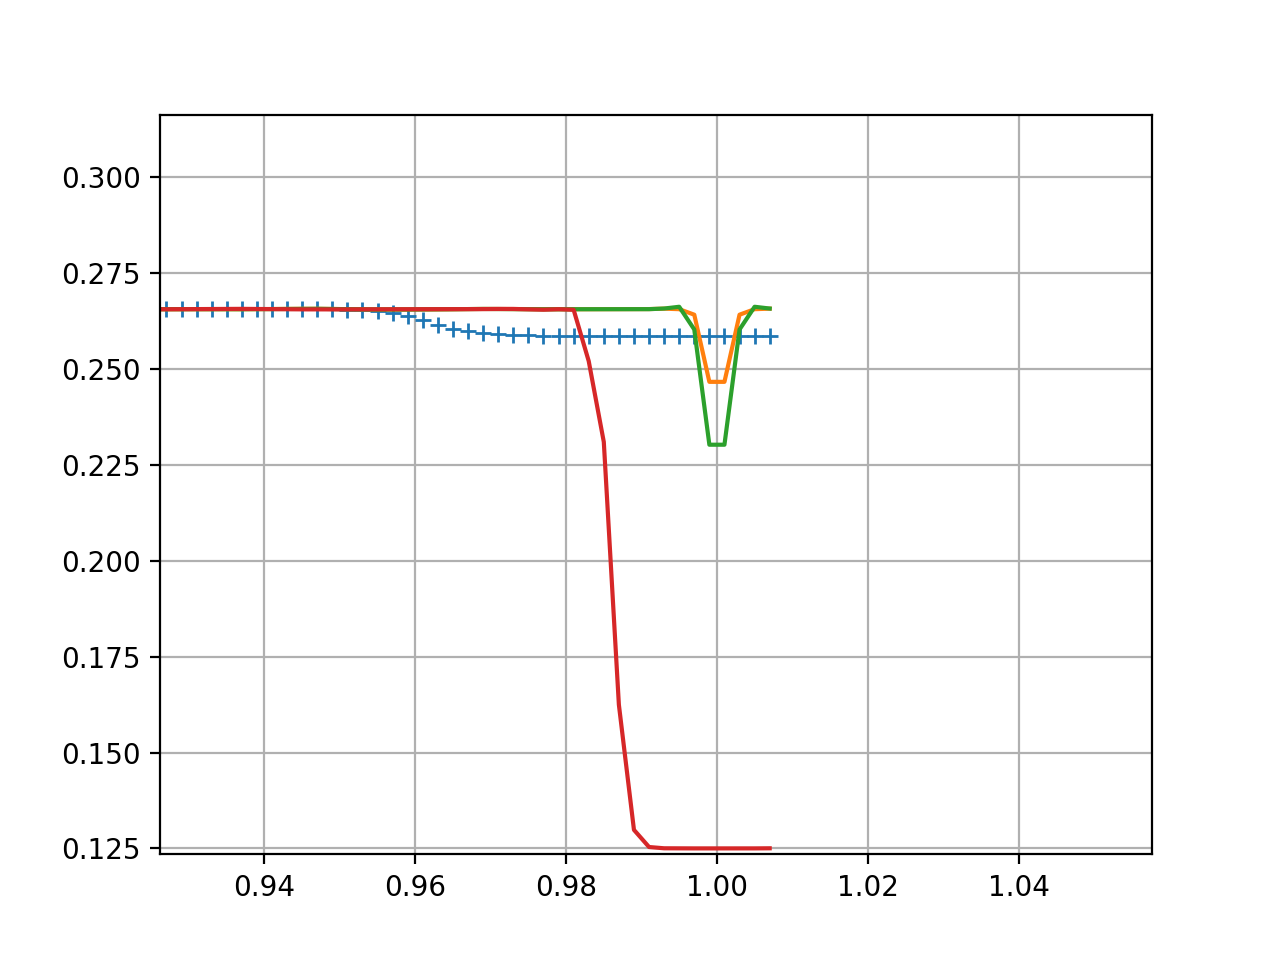

In [34]:
plt.figure()
# plt.plot(Sim.XPos, gfSol[-1][Prim.Dens])
plt.plot(grid.cc, vs[-1][Prim.Dens], '+')
plt.plot(grid.cc, vs[-134][Prim.Dens])
plt.plot(grid.cc, vs[-135][Prim.Dens])
plt.plot(grid.cc, vs[-145][Prim.Dens])
plt.grid()
# plt.plot(Sim.XPos, (vs[-1][Prim.Dens] - gfSol[-1][Prim.Dens]) / vs[-1][Prim.Dens])
# plt.plot(Sim.XPos, vs[-1][Prim.Dens], '+')
# plt.plot(vs[-1][Prim.Pres])
# plt.plot(vs[-1][Prim.Eint])

In [ ]:
vs[-1][Prim.Velo]

In [ ]:
V, U = setup()

In [ ]:
reconstruct_weno(V)

In [ ]:
np.seterr(all='raise')
def lax_friedrichs_flux(primRecon):
    consRecon = np.zeros((Cons.NumVars, primRecon.shape[1], primRecon.shape[2]))
    fluxLR = np.zeros_like(consRecon)
    fluxLR[:, 0, :] = prim2flux(primRecon[:, 0, :])
    fluxLR[:, 1, :] = prim2flux(primRecon[:, 1, :])
    consRecon[:, 0, :] = prim2cons(primRecon[:, 0, :])
    consRecon[:, 1, :] = prim2cons(primRecon[:, 1, :])

    csL = np.sqrt(Gas.Gamma * primRecon[Prim.Pres, 0] / primRecon[Prim.Dens, 0])
    csR = np.sqrt(Gas.Gamma * primRecon[Prim.Pres, 1] / primRecon[Prim.Dens, 1])
    maxC = np.zeros_like(csL)
    # The left hand sound speed is the right hand extrapolation of the cell below,
    # and the left hand one is the right hand extrapolation of the value in the
    # next cell
    maxC[1:] = 0.5 * (csL[:-1] + np.abs(primRecon[Prim.Velo, 1, :-1]) + csR[1:] + np.abs(primRecon[Prim.Velo, 0, 1:]))
    # maxC[1:] = 0.5 * (csL[1:] + np.abs(primRecon[Prim.Velo, 0, 1:]) + csL[:-1] + np.abs(primRecon[Prim.Velo, 0, :-1]))

    flux = np.zeros((Cons.NumVars, primRecon.shape[2]))
    flux[:, 1:] = 0.5 * (fluxLR[:, 1, :-1] + fluxLR[:, 0, 1:] - maxC[1:] * (consRecon[:, 1, 1:] - consRecon[:, 0, :-1]))
    return flux

In [ ]:
plt.figure()
plt.plot(Sim.XPos, V[Cons.Dens])
plt.plot(Sim.XPos - Sim.GrDx/2, reconstruct_weno(V)[Cons.Dens, 0], '+')
plt.plot(Sim.XPos + Sim.GrDx/2, reconstruct_weno(V)[Cons.Dens, 1], '+')

In [ ]:
from Flux import lax_friedrichs_flux

In [ ]:
np.save('lxf_sod.npy', vs)

In [ ]:
np.save('wenonm_sod.npy', vs)

In [ ]:
def weno_nm(q, dx):
    nRows, nGrid = q.shape
    result = np.zeros((nRows, 2, nGrid))

    # Set up general and left/right coefficients.
    # The left/right coeffs are just flipped relative to each other
    Pow = 2
    WenoEps = 1e-34
    EnoCoeffL = np.array(((-2.0/3.0,  -1.0/3.0,  2.0),
                          ( 2.0/3.0,   2.0/3.0, -1.0/3.0),
                          (-1.0/3.0,   2.0/3.0,  2.0/3.0)))
    LinWL = np.array((0.3, 0.6, 0.1))
    EnoCoeffR = np.array((( 2.0,      -1.0/3.0, -2.0/3.0),
                          (-1.0/3.0,   2.0/3.0,  2.0/3.0),
                          ( 2.0/3.0,   2.0/3.0, -1.0/3.0)))
    LinWR = np.array((0.1, 0.6, 0.3))
    # length ratio designated rho
    rho = np.zeros(nGrid)
    rho[:-1] = dx[:-1] / (dx[:-1] + dx[1:])
    # print(rho)
    # rhoPrime is used for the double extrapolation performed for the first stencil
    # rhoPrime = np.zeros(nGrid)
    # rhoPrime[1:] = dx[1:] / (dx[:-1] + dx[1:])

    # Loop over each row in the q matrix - we parallelise over rows
    for row in prange(nRows):
        beta = np.empty((2,3))
        # betaZ = np.empty(3)
        stencil = np.empty((3, 3)) # coords are [left/right, stencilIdx, stencilEntry]
        for i in range(2, nGrid-2):
            # Compute beta, the smoothness indicator for each intepolating polynomial

            q00 = q[row, i-1] + rho[i-1] * (q[row, i-1] - q[row, i-2])
            q01 = rho[i] * q[row, i] + (1.0 - rho[i]) * q[row, i+1]
            q10 = rho[i-1] * q[row, i-1] + (1.0 - rho[i-1])* q[row, i]
            q11 = q[row, i+1] + (1.0 - rho[i+1]) * (q[row, i+1] - q[row, i+2])
            q12 = rho[i+1] * q[row, i+1] + (1.0 - rho[i+1]) * q[row, i+2]
            q21 = rho[i-2] * q[row, i-2] + (1.0 - rho[i-2]) * q[row, i-1]


            # stencil[0, 0] = (2.0 * rhoPrime[i-1] + rho[i-2]) * q[row, i-1] + rhoPrime[i-1] * q[row, i-2]
            # stencil[0, 1] = (1.0 - rho[i-1]) * q[row, i-1] + rho[i-1] * q[row, i]
            # stencil[0, 2] = q[row, i]
            # stencil[1, 0] = stencil[0, 1]
            # stencil[1, 1] = q[row, i]
            # stencil[1, 2] = (1.0 - rho[i]) * q[row, i] + rho[i] * q[row, i+1]
            # stencil[2, 0] = stencil[1, 2]
            # stencil[2, 1] = q[row, i+1]
            # stencil[2, 2] = (1.0 - rho[i+1]) * q[row, i+1] + rho[i+1] * q[row, i+2]

            beta[0, 0] = 13.0/12.0*(2.0*q10 - 2.0*q00)**2 + 0.25*(4.0*q[row, i] - 2.0*q10 - 2.0*q00)**2
            beta[0, 1] = 13.0/12.0*(2.0*q10 - 4.0*q[row, i] + 2.0*q01)**2 + 0.25*(-2.0*q10 + 2.0*q01)**2
            beta[0, 2] = 13.0/12.0*(2.0*q01 - 4.0*q[row, i+1] + 2.0*q12)**2 + 0.25*(-6.0*q01 + 8.0*q[row, i+1] - 2.0*q12)**2

            beta[1, 0] = 13.0/12.0*(2.0*q01 - 2.0*q11)**2 + 0.25*(4.0*q[row, i] - 2.0*q01 - 2.0*q11)**2
            beta[1, 1] = 13.0/12.0*(2.0*q01 - 4.0*q[row, i] + 2.0*q10)**2 + 0.25*(-2.0*q01 + 2.0*q10)**2
            beta[1, 2] = 13.0/12.0*(2.0*q10 - 4.0*q[row, i-1] + 2.0*q21)**2 + 0.25*(-6.0*q10 + 8.0*q[row, i-1] - 2.0*q21)**2
            # tau5 = np.abs(beta[0] - beta[2])
            # betaZ[:] = ((beta + WenoEps) / (beta + tau5 + WenoEps))

            # Compute and normalise the non-linear weights
            nonLinWL = LinWR / (WenoEps + beta[0, :])**Pow
            nonLinWR = LinWR / (WenoEps + beta[1, :])**Pow
            nonLinWL /= np.sum(nonLinWL)
            nonLinWR /= np.sum(nonLinWR)

            # Compute the standard polynomial reconstructions
            enoIntpLR = np.zeros((2, 3))
            # for s in range(3):
            #     enoIntpL[s] = np.dot(stencil[s], EnoCoeffL[2-s]) 
            #     enoIntpR[s] = np.dot(stencil[s], EnoCoeffR[s]) 
            enoIntpLR[0, 0] = ( 6.0*q[row, i] - 1.0*q10         - 2.0*q00)
            enoIntpLR[0, 1] = (-1.0*q10       + 2.0*q[row, i]   + 2.0*q01)
            enoIntpLR[0, 2] = ( 2.0*q01       + 2.0*q[row, i+1] - 1.0*q12)
            enoIntpLR[1, 0] = ( 6.0*q[row, i] - 1.0*q01         - 2.0*q11)
            enoIntpLR[1, 1] = (-1.0*q01       + 2.0*q[row, i]   + 2.0*q10)
            enoIntpLR[1, 2] = ( 2.0*q10       + 2.0*q[row, i-1] - 1.0*q21)
            enoIntpLR /= 3.0

            # Combine the different polynomial reconstrucitions weighted by their non-linear weights
            result[row, 1, i] = np.dot(nonLinWL, enoIntpLR[0, :])
            result[row, 0, i] = np.dot(nonLinWR, enoIntpLR[1, :])
    result[:, 0, :2] = q[:, :2]
    result[:, 1, :2] = q[:, :2]
    result[:, 0, -2:] = q[:, -2:]
    result[:, 1, -2:] = q[:, -2:]
    return result